<a href="https://colab.research.google.com/github/egemengulpinar/Image-Super-Resolution-SRCNN-notes/blob/main/omniglot_dataset_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
import torch.nn.functional as F

In [13]:
#transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 20
train_set=datasets.Omniglot('./data',background=True,download=True,transform=transforms.ToTensor())
test_set=datasets.Omniglot('./data',background=False,download=True,transform=transforms.ToTensor())

trainloader=torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
testloader=torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
new_x = []
new_y = []
for data in trainloader:

  new_y.extend(data)

In [15]:
# print(len(new_x))

print(len(new_y))

1928


In [16]:
class Omniglot(nn.Module):
  def __init__(self):
    super(Omniglot,self).__init__()
    self.conv1=nn.Conv2d(1,32,kernel_size=3)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.conv4=nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1)
    self.conv5=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.conv6=nn.Conv2d(256,256,kernel_size=3,padding=1)
    self.relu=nn.ReLU()
    self.mpool=nn.MaxPool2d(2)
    self.batchNorm1=nn.BatchNorm2d(64)
    self.batchNorm2=nn.BatchNorm2d(128)
    self.batchNorm3=nn.BatchNorm2d(256)
    self.dropout=nn.Dropout(p=0.5)
    self.flatten=nn.Flatten()
    self.linear1=nn.Linear(2304,2000)
    self.linear2=nn.Linear(2000,1800)
    self.linear3=nn.Linear(1800,1623)

  def forward(self,x):
    hidden=self.relu(self.conv1(x))
    hidden=self.relu(self.conv2(hidden))
    hidden=self.batchNorm1(self.mpool(hidden))

    hidden=self.relu(self.conv3(hidden))
    hidden=self.relu(self.conv4(hidden))
    hidden=self.batchNorm2(self.mpool(hidden))

    hidden=self.relu(self.conv5(hidden))
    hidden=self.relu(self.conv6(hidden))
    hidden=self.batchNorm3(self.mpool(hidden))

    # print(hidden.shape)
    flat=hidden.view(-1,2304)
    # flat=self.flatten(hidden)
    linear=self.linear1(flat)
    linear=self.relu(linear)
    ##2, 256 , 9 , 9
    linear=self.linear2(linear)
    linear=self.relu(linear)
    linear=self.linear3(linear)

    return linear

In [17]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
learning_rate = 0.001
model = Omniglot()
model.to(device)
summary(model,(1,105,105))
loss_fn=nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 103, 103]             320
              ReLU-2         [-1, 32, 103, 103]               0
            Conv2d-3           [-1, 64, 52, 52]          18,496
              ReLU-4           [-1, 64, 52, 52]               0
         MaxPool2d-5           [-1, 64, 26, 26]               0
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7          [-1, 128, 26, 26]          73,856
              ReLU-8          [-1, 128, 26, 26]               0
            Conv2d-9          [-1, 128, 13, 13]         147,584
             ReLU-10          [-1, 128, 13, 13]               0
        MaxPool2d-11            [-1, 128, 6, 6]               0
      BatchNorm2d-12            [-1, 128, 6, 6]             256
           Conv2d-13            [-1, 256, 6, 6]         295,168
             ReLU-14            [-1, 25

In [18]:
train_losses=[]
train_accu=[]
deneme_x = []
deneme_y = []
def train(epoch):
  print('\nEpoch : %d'%epoch)

  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):

    inputs,labels=data[0].to(device),data[1].to(device)
    print(inputs)
    deneme_x.extend(inputs)


    deneme_y.extend(labels)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total

  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [19]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)

      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))



In [ ]:
epochs=2
for epoch in range(1,epochs+1):
  train(epoch)
  test(epoch)

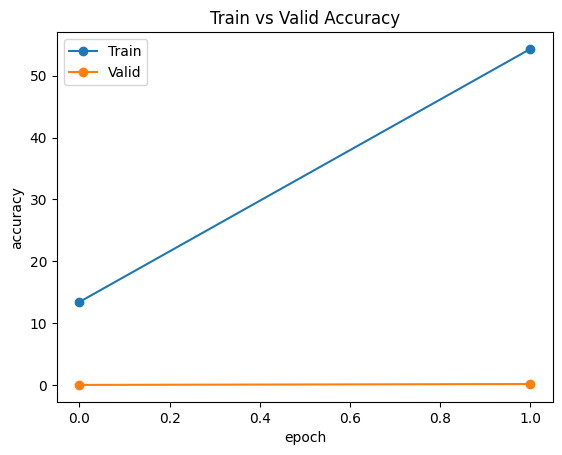

In [21]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

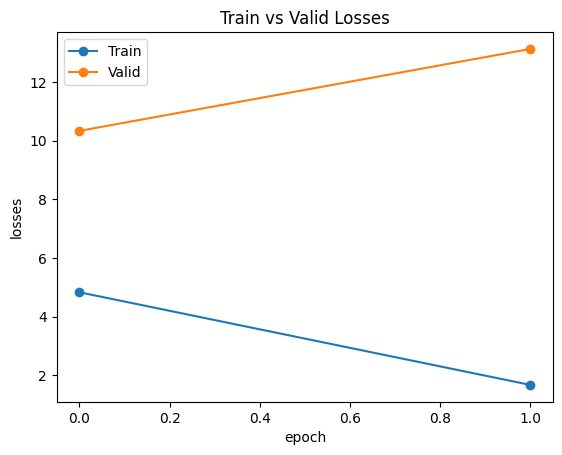

In [22]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()